##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


class 0: (265037, 5)
class 1: (5147, 5)
total class of 1 and0: 0    5147
1    5147
Name: label, dtype: int64
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


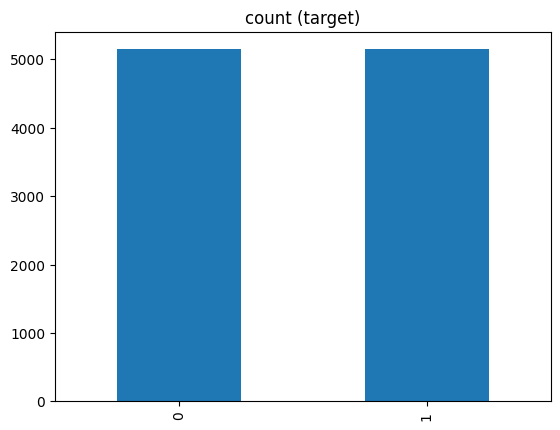

In [ ]:
import pandas as pd
# import tensorflow as tf

# Load the CSV file into a Pandas DataFrame
data = pd.read_csv('/content/intent_class_dataset2')

from sklearn import preprocessing
from keras.utils import to_categorical
label = preprocessing.LabelEncoder()
y = label.fit_transform(data['intent'])
data['label'] = y
# class count
class_count_0, class_count_1 = data['label'].value_counts()

# Separate class
class_0 = data[data['label'] == 0]
class_1 = data[data['label'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
class_0_under = class_0.sample(class_count_1)

data = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and0:",data['label'].value_counts())# plot the count after under-sampeling
data['label'].value_counts().plot(kind='bar', title='count (target)')

df = data.copy()
# Split the DataFrame into training and testing sets
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# Create a TensorFlow Dataset from the training and testing sets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['parent'].values, train_df['label'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['parent'].values, test_df['label'].values))

# Print the element spec of the training dataset
print(train_dataset.element_spec)


In [ ]:
# dataset, info = tfds.load('imdb_reviews', with_info=True,
#                           as_supervised=True)
# train_dataset, test_dataset = dataset['train'], dataset['test']

# train_dataset.element_spec

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'Hello, I\xe2\x80\x99m current student highly interested CSPI. I\xe2\x80\x99m currently working meeting weight requirements (max height 202, I\xe2\x80\x99m 210) putting application. However, two main questions. 1. time application 85 credits complete, working another 12. would 5 credits short academically senior. However, due change major second year, 2 years following summer semester. Would academic credits close senior cause problems application? know scholarship sophomores juniors, want check won\xe2\x80\x99t issue. 2. chosen CSPI, point monthly payment begin (base+BAH). Would begin shortly getting scholarship, begin boot camp following summer. I\xe2\x80\x99m guessing later wasn\xe2\x80\x99t sure couldn\xe2\x80\x99t find answer online.'
label:  1


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Due mental health issues left school 16 done close nothing since. work history amounts around month, neither employers would give good reference. "life experience" like people age have. I\'ve isolated society. get GCSEs. got one English topics B other, along B Maths. grades probably averaged around C. capable better did, pay much attention school, bunked off, revise etc. really want get life track would ultimately like go university. Philosophy interesting topic me, ideally would like study "good" university. know access courses, mum sister trying convince bad idea. say likely rejected good unis access course, since life experience mediocre GCSEs. say take bunch GCSEs (Maths, sciences, couple others) preferably take A-levels perhaps access course. also say way I\'ll get better idea enjoy studying. truth not? much mediocre GCSEs decade ago matter? lack "life experience" (relative I\'d presumably get extra time required re-do GCSEs A-levels) hurt me? top unis think access cour

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'market', 'like', 'im', 'would', 'one', 'get', 'time',
       'it', 'also', 'ampx200b', '2', 'revenue', 'i', 'the', '3', 'know',
       'want', 'people'], dtype='<U28')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[267, 539,  97, ...,   0,   0,   0],
       [247, 641, 263, ...,   0,   0,   0],
       [  1, 809, 530, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Due mental health issues left school 16 done close nothing since. work history amounts around month, neither employers would give good reference. "life experience" like people age have. I\'ve isolated society. get GCSEs. got one English topics B other, along B Maths. grades probably averaged around C. capable better did, pay much attention school, bunked off, revise etc. really want get life track would ultimately like go university. Philosophy interesting topic me, ideally would like study "good" university. know access courses, mum sister trying convince bad idea. say likely rejected good unis access course, since life experience mediocre GCSEs. say take bunch GCSEs (Maths, sciences, couple others) preferably take A-levels perhaps access course. also say way I\'ll get better idea enjoy studying. truth not? much mediocre GCSEs decade ago matter? lack "life experience" (relative I\'d presumably get extra time required re-do GCSEs A-levels) hurt me? top unis think access co

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[0.00616884]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 111ms/step
[0.00616884]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
129/129 [==============================] - 90s 618ms/step - loss: 0.5738 - accuracy: 0.7010 - val_loss: 0.3949 - val_accuracy: 0.9464
Epoch 2/5
129/129 [==============================] - 79s 620ms/step - loss: 0.2531 - accuracy: 0.9604 - val_loss: 0.1588 - val_accuracy: 0.9661
Epoch 3/5
129/129 [==============================] - 72s 563ms/step - loss: 0.1126 - accuracy: 0.9763 - val_loss: 0.0941 - val_accuracy: 0.9745
Epoch 4/5
129/129 [==============================] - 61s 475ms/step - loss: 0.0733 - accuracy: 0.9828 - val_loss: 0.0688 - val_accuracy: 0.9797
Epoch 5/5
129/129 [==============================] - 46s 359ms/step - loss: 0.0553 - accuracy: 0.9871 - val_loss: 0.0558 - val_accuracy: 0.9833


In [ ]:
model.save('/content/drive/MyDrive/NLP_project/models/seq_model')

In [ ]:
# It can be used to reconstruct the model identically.
model = tf.keras.models.load_model("/content/drive/MyDrive/NLP_project/models/seq_model")

# # Let's check:
# np.testing.assert_allclose(
#     model.predict(test_dataset), model.predict(test_dataset)
# )

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
# reconstructed_model.fit(test_dataset, test_target)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

33/33 [==============================] - 4s 26ms/step - loss: 0.0526 - accuracy: 0.9835
Test Loss: 0.05259351059794426
Test Accuracy: 0.9834871292114258


(0.0, 0.5997411243617534)

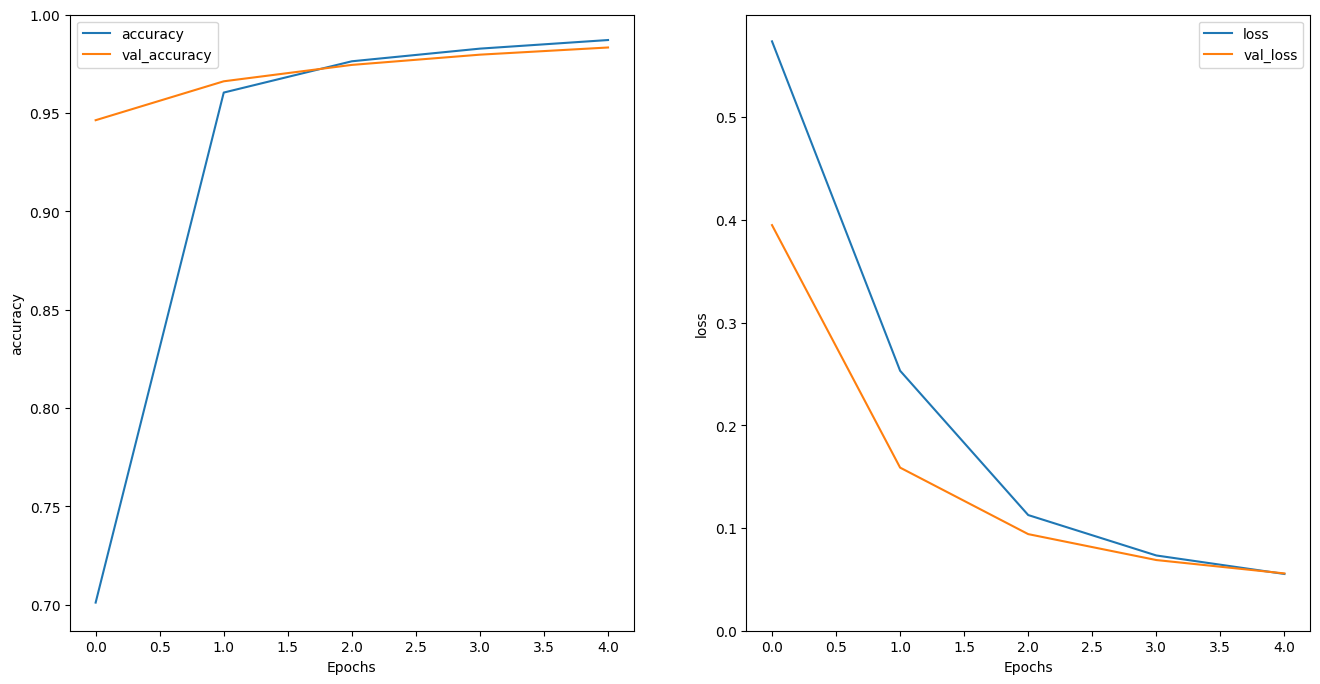

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
#chitchat sample class =0
sample_text = ('No, Its just adjusting to a time change')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 3s 3s/step
[[-9.936377]]


In [ ]:
#reddit sample class =1
sample_text = ('Ive havng Otter Pops mpre often starting become summer, ive always wondered liquid pop would always kind "freeze" flick it. (Well, like slush-consistency). really interesting, want know.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 23ms/step
[[14.846942]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

In [ ]:
model.save('/content/drive/MyDrive/NLP_project/models/seq_model2')

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

#chitchat sample
sample_text = ('No, Its just adjusting to a time change')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
# predict on a sample text without padding.

#reddit sample
sample_text = ('Ive havng Otter Pops mpre often starting become summer, ive always wondered liquid pop would always kind "freeze" flick it. (Well, like slush-consistency). really interesting, want know.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
